# Pre-Paid Card Marketing

## Data Preprocessing

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import utils

In [5]:
df = pd.read_csv('../data/Financial Wellness Data.csv')
df

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,11220,3,3,6,7,7,61,3,3,1,...,1,2,3,0,0,0,1,2,-5,0.522504
6390,13118,3,2,7,7,7,59,3,4,2,...,1,3,6,0,0,0,0,3,-5,1.015219
6391,8709,1,3,5,6,6,59,3,4,3,...,1,1,2,0,0,0,0,2,0,1.136270
6392,8515,1,3,5,5,5,46,2,2,3,...,1,4,9,0,0,0,0,2,0,1.224941


In [6]:
# find duplicates
df[df.duplicated()]

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt


In [7]:
# check for missing values
df.isnull().sum()

PUF_ID         0
sample         0
fpl            0
SWB_1          0
SWB_2          0
              ..
PPT612         0
PPT1317        0
PPT18OV        0
PCTLT200FPL    0
finalwt        0
Length: 217, dtype: int64

In [8]:
# check the data types
df.dtypes

PUF_ID           int64
sample           int64
fpl              int64
SWB_1            int64
SWB_2            int64
                ...   
PPT612           int64
PPT1317          int64
PPT18OV          int64
PCTLT200FPL      int64
finalwt        float64
Length: 217, dtype: object

In [9]:
# check if any features have zero variance
df.var() == 0

PUF_ID         False
sample         False
fpl            False
SWB_1          False
SWB_2          False
               ...  
PPT612         False
PPT1317        False
PPT18OV        False
PCTLT200FPL    False
finalwt        False
Length: 217, dtype: bool

## Exploratory Data Analysis

In [10]:
# Describe the data
df.describe()

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
count,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,...,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000
mean,10892.392712,1.279794,2.658899,5.353769,5.362215,5.432280,56.034094,3.048014,3.191899,2.531279,...,0.866124,2.644823,5.145605,0.035815,0.078511,0.129653,0.122928,2.084298,-0.081952,1.000000
std,1967.854493,0.570187,0.656944,1.500913,1.544942,1.613876,14.154676,1.235221,1.114130,1.196235,...,0.340545,1.032583,2.529397,0.185843,0.268995,0.335947,0.328380,0.814345,1.328498,0.585406
min,7123.000000,1.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.000000,0.165567
25%,9235.250000,1.000000,3.000000,5.000000,5.000000,5.000000,48.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.600582
50%,10901.500000,1.000000,3.000000,6.000000,6.000000,6.000000,56.000000,3.000000,3.000000,2.000000,...,1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.845213
75%,12570.750000,1.000000,3.000000,6.000000,7.000000,7.000000,65.000000,4.000000,4.000000,3.000000,...,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.251415
max,14400.000000,3.000000,3.000000,7.000000,7.000000,7.000000,95.000000,5.000000,5.000000,5.000000,...,1.000000,4.000000,9.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,6.638674


## Feature Engineering

In [11]:
# Split the data into features and target
X = df.drop(columns=['PUF_ID', 'PRODUSE_3'])
y = df['PRODUSE_3']

### Dummify the categorical variables

In [12]:
# dummify any integer columns
integer_variables = X.select_dtypes(include=['int64']).columns
df_categorical = X[integer_variables].astype('object')
df_numeric = X.drop(columns=integer_variables)

# dummify the categorical variables
df_dummies = pd.get_dummies(df_categorical, drop_first=True)
X = pd.concat([df_numeric, df_dummies], axis=1)
X

,KHscore,finalwt,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,1.267,0.367292,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,-0.570,1.327561,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,-0.188,0.835156,False,False,False,True,False,False,False,False,...,True,False,False,False,True,True,False,False,False,True
3,-1.485,1.410871,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,-1.900,4.260668,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,1.267,0.522504,False,True,False,True,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
6390,-1.215,1.015219,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6391,-1.215,1.136270,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
6392,-1.215,1.224941,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False


In [13]:
# convert the one-hot encoded data to integers
X = X.astype('float64')
X

,KHscore,finalwt,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,1.267,0.367292,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.570,1.327561,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.188,0.835156,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,-1.485,1.410871,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.900,4.260668,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,1.267,0.522504,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6390,-1.215,1.015219,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6391,-1.215,1.136270,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6392,-1.215,1.224941,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Remove Highly Correlated Features

In [14]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, correlation_threshold=0.9, variance_threshold=0.05)
X_vif

Removed highly correlated variables: ['DISCOUNT_2', 'BENEFITS_1_1', 'KHKNOWL5_2', 'KHKNOWL4_2', 'KH6correct_1', 'KH3correct_1', 'EMPLOY1_8_1', 'SOCSEC2_-2', 'FK3correct_1', 'FINSOC2_1_1', 'FINSOC2_3_1', 'KH5correct_1', 'FINSOC2_2_1', 'BORROW_1_1', 'KH4correct_1', 'KH8correct_1', 'KH7correct_1', 'PAIDHELP_0', 'EMPLOY1_4_1', 'BENEFITS_5_1', 'KHKNOWL9_2', 'KH9correct_1', 'FINSOC2_5_1', 'FINSOC2_4_1', 'FINSOC2_7_1', 'MEMLOSS_1', 'FK2correct_1', 'EMPLOY1_2_1', 'Military_Status_5', 'BENEFITS_4_1', 'FINGOALS_1', 'REJECTED_1_1', 'FK1correct_1', 'BENEFITS_2_1', 'CONSPROTECT3_1', 'FINKNOWL3_2', 'KHKNOWL6_2', 'KH2correct_1', 'BENEFITS_3_1', 'KH1correct_1', 'ON1correct_1', 'REJECTED_2_1', 'FINSOC2_6_1', 'MILITARY_1', 'BORROW_2_1']


Removed variable: PCTLT200FPL_0 with VIF: 666911995237093.50
Removed variable: PPREG4_4 with VIF: 533151394272280.44
Removed variable: FWB2_2_3 with VIF: 3280.82
Removed variable: LMscore_3 with VIF: 2022.52
Removed variable: FWB1_4_3 with VIF: 1330.20
Removed variable: FWB2_1_2 with VIF: 1119.18
Removed variable: MANAGE1_3_5 with VIF: 558.36
Removed variable: FWB1_5_3 with VIF: 511.65
Removed variable: FWB2_4_3 with VIF: 420.01
Removed variable: FWB1_1_3 with VIF: 347.94
Removed variable: FS1_5_3 with VIF: 278.11
Removed variable: FWB1_2_3 with VIF: 263.54
Removed variable: KHKNOWL1_3 with VIF: 242.06
Removed variable: FINKNOWL2_3 with VIF: 216.04
Removed variable: SOCSEC1_1 with VIF: 140.42
Removed variable: KHKNOWL2_3 with VIF: 125.13
Removed variable: KIDS_4_0 with VIF: 121.44
Removed variable: KHKNOWL8_2 with VIF: 91.11
Removed variable: HOUSING_1 with VIF: 89.93
Removed variable: DISTRESS_3 with VIF: 72.66
Removed variable: OUTLOOK_1_4 with VIF: 71.70
Removed variable: FINKNOWL1_

,finalwt,sample_2,sample_3,fpl_2,SWB_1_4,SWB_1_5,SWB_1_6,SWB_2_4,SWB_2_5,SWB_2_6,...,PPREG9_5,PPREG9_7,PPREG9_8,PPREG9_9,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_3,PPT18OV_4,PCTLT200FPL_1
0,0.367292,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.327561,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.835156,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.410871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.260668,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.522504,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6390,1.015219,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6391,1.136270,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6392,1.224941,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the Data

In [15]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, stratify=y, random_state=42)

### Standardize the Data

In [16]:
# standardize the data
# only standardize the "finalwt" column
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['finalwt'] = scaler.fit_transform(X_train[['finalwt']])
X_test_scaled['finalwt'] = scaler.transform(X_test[['finalwt']])

# reset index
X_train_scaled.reset_index(drop=True, inplace=True)
X_test_scaled.reset_index(drop=True, inplace=True)
X_train_scaled

,finalwt,sample_2,sample_3,fpl_2,SWB_1_4,SWB_1_5,SWB_1_6,SWB_2_4,SWB_2_5,SWB_2_6,...,PPREG9_5,PPREG9_7,PPREG9_8,PPREG9_9,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_3,PPT18OV_4,PCTLT200FPL_1
0,-0.665352,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.995296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.788317,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.490516,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.082103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,-0.564364,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5111,0.357857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5112,0.244296,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5113,-0.897709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Logistic Regression to Find Important Features

In [17]:
# Reset the index of y_train to match X_train_scaled_const
y_train_scaled = y_train.reset_index(drop=True)

X_train_scaled_const = sm.add_constant(X_train_scaled)

logit_model = sm.Logit(y_train_scaled, X_train_scaled_const).fit_regularized(method='l1', alpha=3)
print(logit_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11362476605075092
            Iterations: 289
            Function evaluations: 290
            Gradient evaluations: 289
                           Logit Regression Results                           
Dep. Variable:              PRODUSE_3   No. Observations:                 5115
Model:                          Logit   Df Residuals:                     4915
Method:                           MLE   Df Model:                          199
Date:                Wed, 06 Nov 2024   Pseudo R-squ.:                  0.6944
Time:                        23:47:47   Log-Likelihood:                -464.13
converged:                       True   LL-Null:                       -1518.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

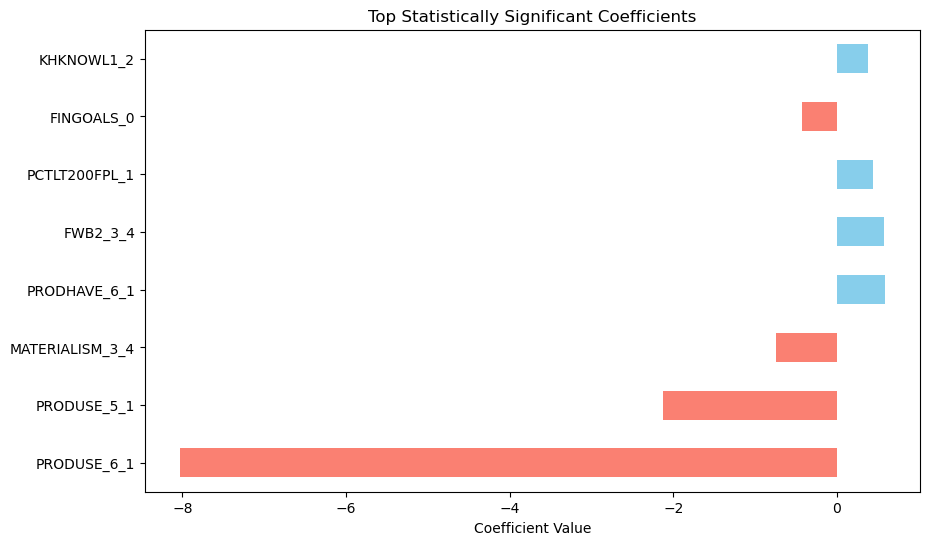

In [20]:
# Get the coefficients and p-values
coefficients = logit_model.params
p_values = logit_model.pvalues

# Create a DataFrame to hold coefficients and p-values for easier processing
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Filter out statistically significant coefficients (e.g., p-value < 0.05)
significant_coefs = coef_df[coef_df['P-Value'] < 0.05]

# Sort coefficients by absolute value (to find the top 20 largest), keeping the sign
top_coefs = significant_coefs['Coefficient'].abs().sort_values(ascending=False).head(20).index

# Filter the original coefficients DataFrame to get the top 20 largest coefficients (with signs)
top_coefs_with_signs = significant_coefs.loc[top_coefs]

# Plot the top 20 largest coefficients with their signs
plt.figure(figsize=(10, 6))
top_coefs_with_signs['Coefficient'].plot(kind='barh', color=['skyblue' if coeff >= 0 else 'salmon' for coeff in
                                                             top_coefs_with_signs['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Top Statistically Significant Coefficients')
plt.show()

PRODUSE_6 is endogenous, since these are respondents who did not select any items in PRODUSE bank.

In [22]:
# take the top coefficients and create a new dataframe
top_features = top_coefs_with_signs.index

# drop produse_6
top_features = top_features.drop('PRODUSE_6_1')

X_train_top_features = X_train_scaled[top_features]
X_test_top_features = X_test_scaled[top_features]
X_train_top_features

,PRODUSE_5_1,MATERIALISM_3_4,PRODHAVE_6_1,FWB2_3_4,PCTLT200FPL_1,FINGOALS_0,KHKNOWL1_2
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5110,1.0,1.0,1.0,0.0,0.0,0.0,0.0
5111,1.0,0.0,1.0,1.0,1.0,1.0,0.0
5112,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5113,0.0,0.0,1.0,0.0,0.0,0.0,0.0
